## _*Variational Quantum Classifier*_

The QSVM notebook demonstrates a kernel based approach. This notebook shows a variational method.

For further information please see: [https://arxiv.org/pdf/1804.11326.pdf](https://arxiv.org/pdf/1804.11326.pdf)


**This notebook shows the variational quantum classifier method.**

In this file, we show two ways for using the variational quantum classifier: (1) the declarative approach and (2) the programmatic approach. 


### Part I: declarative approach.
In the declarative approach, we config a json-like configuration, which defines how the vqc instance is internally constructed. After the execution, it returns the json-like output, which carries the important information (e.g., the details of the vqc instance) and the processed results. 

In [1]:
from datasets import *
from qiskit import BasicAer
from qiskit.aqua import run_algorithm, QuantumInstance
from qiskit.aqua.algorithms import VQC
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.feature_maps import SecondOrderExpansion
from qiskit.aqua.components.variational_forms import RYRZ
from qiskit.aqua.utils import split_dataset_to_data_and_labels, map_label_to_class_name
from qiskit.aqua.input import ClassificationInput

First we prepare the dataset, which is used for training, testing and the finally prediction.

*Note: You can easily switch to a different dataset, such as the Breast Cancer dataset, by replacing 'ad_hoc_data' to 'Breast_cancer' below.*

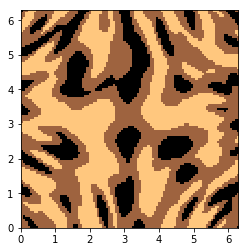

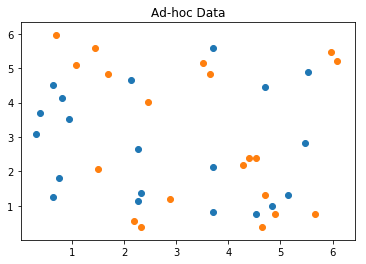

{'A': 0, 'B': 1}


In [2]:
feature_dim = 2 # dimension of each data point
training_dataset_size = 20
testing_dataset_size = 10
random_seed = 10598
shots = 1024

sample_Total, training_input, test_input, class_labels = ad_hoc_data(
    training_size=training_dataset_size, 
    test_size=testing_dataset_size, 
    n=feature_dim, gap=0.3, PLOT_DATA=True
)
datapoints, class_to_label = split_dataset_to_data_and_labels(test_input)
print(class_to_label)

Now we create the vqc in the declarative approach.
In the following json, we config:
- the algorithm name 
- the variational form
- the feature map 
- the optimizer

In [3]:
params = {
    'problem': {'name': 'classification', 'random_seed': 10598},
    'algorithm': {'name': 'VQC', 'override_SPSA_params': True},
    'backend': {'shots': 1024},
    'optimizer': {'name': 'SPSA', 'max_trials': 200, 'save_steps': 1},
    'variational_form': {'name': 'RYRZ', 'depth': 3},
    'feature_map': {'name': 'SecondOrderExpansion', 'depth': 2}
}

classification_input = ClassificationInput(training_input, test_input, datapoints[0])
backend = BasicAer.get_backend('qasm_simulator')

With everything setup, we can now run the algorithm.

For the testing, the result includes the details and the success ratio.

For the prediction, the result includes the predicted labels. 

In [4]:
result = run_algorithm(params, classification_input, backend=backend)
print("testing success ratio: ", result['testing_accuracy'])
print("predicted classes:", result['predicted_classes'])

testing success ratio:  1.0
predicted classes: ['A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'A', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B']


### Part II: programmatic approach.
We construct the vqc instance directly from the classes. The programmatic approach offers the users better accessibility, e.g., the users can access the internal state of vqc instance or invoke the methods of the instance. 

Now we create the vqc in the programmatic approach.
- we build the optimizer instance (required by the vqc instance) by instantiating the class SPSA.
- We build the feature map instance (required by the vqc instance) by instantiating the class SecondOrderExpansion.
- We build the varitional form instance (required by the vqc instance) by instantiating the class RYRZ.
- We build the vqc instance by instantiating the class VQC. 


In [5]:
backend = BasicAer.get_backend('qasm_simulator')
optimizer = SPSA(max_trials=100, c0=4.0, skip_calibration=True)
optimizer.set_options(save_steps=1)
feature_map = SecondOrderExpansion(feature_dimension=feature_dim, depth=2)
var_form = RYRZ(num_qubits=feature_dim, depth=3)
vqc = VQC(optimizer, feature_map, var_form, training_input, test_input)
quantum_instance = QuantumInstance(backend, shots=shots, seed=random_seed, seed_transpiler=random_seed)

Now we run it.

In [6]:
result = vqc.run(quantum_instance)
print("testing success ratio: ", result['testing_accuracy'])

testing success ratio:  1.0


Different from the declarative approach, the programmatic approach allows the users to invoke APIs upon the vqc instance directly. In the following, we invoke the API "predict" upon the trained vqc instance to predict the labels for the newly provided data input.

Use the trained model to evaluate data directly, and we store a label_to_class and class_to_label for helping converting between label and class name

In [7]:
predicted_probs, predicted_labels = vqc.predict(datapoints[0])
predicted_classes = map_label_to_class_name(predicted_labels, vqc.label_to_class)
print("prediction:   {}".format(predicted_labels))

prediction:   [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
